# Background
- Need an updated set of numbers for the |B| regression based on slow controls for use with probe rotation data -- NMR is out

# Imports

In [276]:
import math
import numpy as np
import pandas as pd
import pickle as pkl
from datetime import datetime
from dateutil import parser
from datetime import datetime
from sys import getsizeof
import re

import operator
from scipy import stats
import scipy.optimize as optimization
import lmfit as lm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['axes.axisbelow'] = True

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.express as px
init_notebook_mode(True)

#import seaborn as sns
from wand.image import Image as WImage

from hallprobecalib import hpc_ext_path
#from hallprobecalib.hpcplots import scatter2d,scatter3d,histo,py_profile
from hallprobecalib.hpcplots import scatter2d,scatter3d,histo

In [277]:
directory = "/home/ckampa/Dropbox/LogFiles/"
# filename_slow = '2020-03-16 124657slow.txt' # long shutdown, magnet off most of the time
#filename_slow = '2020-06-18 124943slow.txt' # strong floor temp dependence...step function for NMR
filename_slow = '2020-06-26 105702slow.txt'
#filename_slow = '2020-07-07 125125slow.txt'

# Load/Clean Data

In [278]:
df = pd.read_csv(directory+filename_slow)
df.columns = df.columns.str.lstrip(" ")
dates = [parser.parse(row.Time) for row in df.itertuples()]# if isdatetime(row.Time.values[0])]
df["Datetime"] = pd.to_datetime(dates)#.astype("str")
df = df.set_index("Datetime")

In [279]:
#df.columns

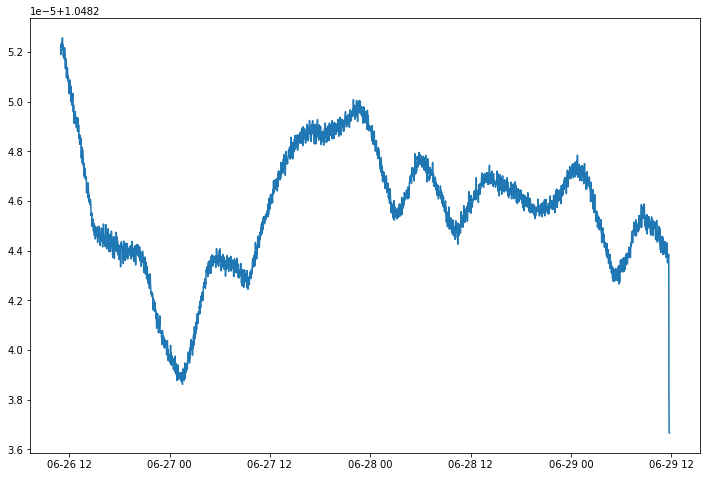

In [280]:
plt.plot(df.index, df['NMR [T]'])

In [281]:
df = df[df['NMR [T]'] > 1e-2]

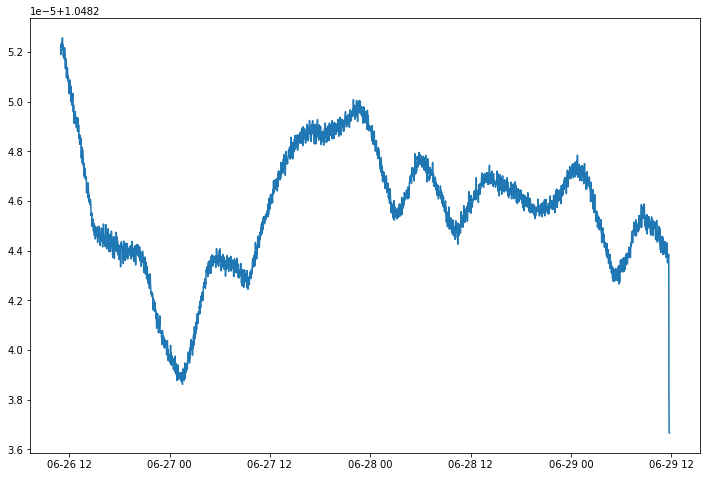

In [282]:
plt.plot(df.index, df['NMR [T]'])

In [283]:
(df['NMR [T]'] - df['NMR [T]'].rolling(3).mean()).std()

1.8205087652981614e-07

In [284]:
df['Magnet Current [A]']

Datetime
2020-06-26 10:57:51    192.055007
2020-06-26 10:59:21    192.054950
2020-06-26 11:00:51    192.054950
2020-06-26 11:02:21    192.054950
2020-06-26 11:03:51    192.055120
                          ...    
2020-06-29 11:41:27    192.054440
2020-06-29 11:42:56    192.054440
2020-06-29 11:44:27    192.054440
2020-06-29 11:45:57    192.054553
2020-06-29 11:47:19    201.656720
Name: Magnet Current [A], Length: 2914, dtype: float64

In [285]:
sigma_NMR = (df['NMR [T]'] - df['NMR [T]'].rolling(3).mean()).std()

In [286]:
sigma_NMR

1.8205087652981614e-07

In [294]:
#df_dmm

In [298]:
#scatter2d(df_dmm['Magnet Current [A]'], df_dmm['NMR [T]'],lines=False, inline=False)

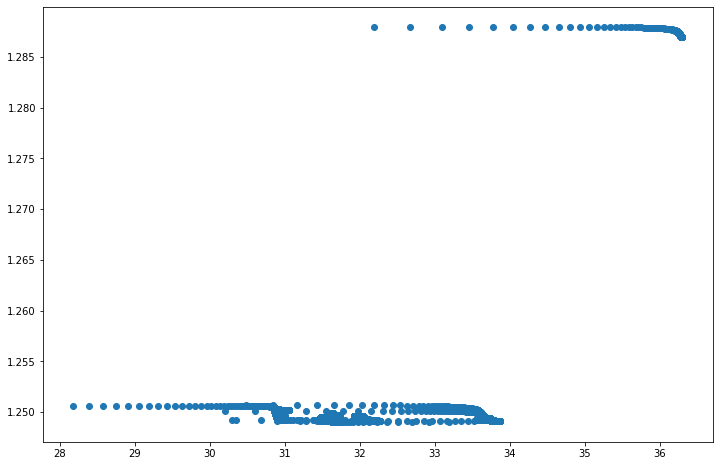

In [309]:
plt.scatter(df_dmm['Magnet Voltage [V]'], df_dmm['NMR [T]'])

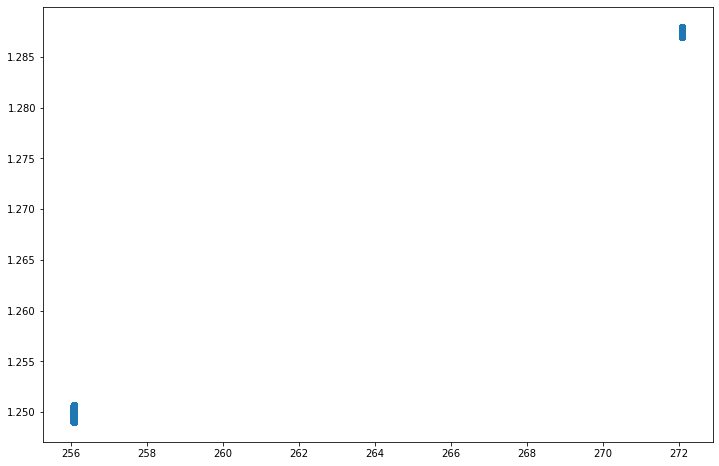

In [295]:
plt.scatter(df_dmm['Magnet Current [A]'], df_dmm['NMR [T]'])

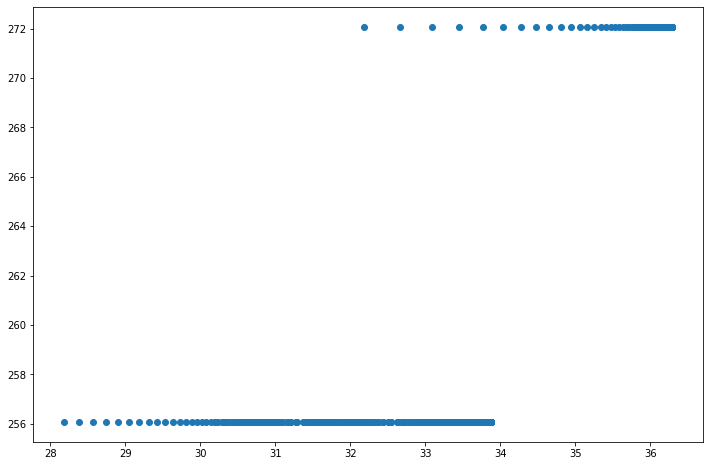

In [310]:
plt.scatter(df_dmm['Magnet Voltage [V]'], df_dmm['Magnet Current [A]'])

In [296]:
len(df_dmm)

90525

# Model

In [299]:
def B_model(data_array, **params):
    CURRENT, YOKE, ENC, WATER = data_array
    return params['A'] * YOKE + params['B'] * ENC + params['C'] * WATER + params['D'] * CURRENT + params['E']

def B_model2(data_array, **params):
    CURRENT, YOKE, ENC, WATER = data_array
    return params['A'] * YOKE + params['B'] * ENC + params['C'] * WATER + params['D'] * CURRENT# + params['E']

def B_model3(data_array, **params):
    CURRENT, VOLTAGE = data_array
    return params['A'] * CURRENT + params['B'] * 1/VOLTAGE + params['C'] #* WATER + params['D'] * CURRENT# + params['E']

def B_model4(data_array, **params):
    CURRENT, VOLTAGE = data_array
    return params['A'] * CURRENT + params['B'] * VOLTAGE / CURRENT + params['C'] #* WATER + params['D'] * CURRENT# + params['E']

In [314]:
#model = lm.Model(B_model, independent_vars=['data_array'])
#model = lm.Model(B_model2, independent_vars=['data_array'])
model = lm.Model(B_model4, independent_vars=['data_array'])
params = lm.Parameters()
params.add('A', value=0)
params.add('B', value=0, vary=False)
params.add('C', value=0, vary=True)
#params.add('D', value=0)
#params.add('E', value=0)

In [315]:
data = df[["Magnet Current [A]","Magnet Voltage [V]"]].values.T
samples = df['NMR [T]'].values

result = model.fit(samples, data_array=data, params=params, weights=1/sigma_NMR)

In [316]:
result

In [ ]:
plt.scatter()

In [289]:
data = df[["Magnet Current [A]","Yoke (center magnet)","Floor","LCW in Coil 2"]].values.T
samples = df['NMR [T]'].values

result = model.fit(samples, data_array=data, params=params, weights=1/sigma_NMR)

In [290]:
result

In [200]:
model = lm.Model(B_model3, independent_vars=['data_array'])
params = lm.Parameters()
params.add('A', value=0)
params.add('B', value=0, vary=True)
params.add('C', value=0)

In [201]:
data = df[["Magnet Current [A]","Magnet Voltage [V]"]].values.T
samples = df['NMR [T]'].values

result = model.fit(samples, data_array=data, params=params, weights=1/sigma_NMR)

In [202]:
result

In [203]:
from scipy.stats import chi2

In [215]:
1 - chi2.cdf(result.chisqr*.0075, len(result.data)-3)

0.4201704479229511

In [91]:
for p in result.params.keys():
    print(f'{p} = {result.params[p].value}; ', end='')

A = 0.005451740619843297; B = 0.028162518418453145; 

In [51]:
result.params.keys()

odict_keys(['A', 'B', 'C', 'D'])

# Looking at Old

In [92]:
pkldir = hpc_ext_path+"datafiles/magnet_stability/pkl/"

In [94]:
df_old = pd.read_pickle(pkldir+"magnet_stability_all.pkl")

In [95]:
df_old

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,NMR [FFT],Zaber_Meas_MicroStep_X,Zaber_Meas_Encoder_X,Zaber_Meas_MicroStep_Y,Zaber_Meas_Encoder_Y,Zaber_Meas_MicroStep_Z,Zaber_Meas_Encoder_Z,seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-07-16 10:12:40,7/16/2019 10:12:40 AM,256.069238,33.803850,55.239761,52.688934,31.030971,34.043785,32.280407,38.443527,29.436894,...,0.0,210351.56250,538500.0,178906.250000,458000.0,642578.125,1645000.0,0.0,0.000000,0.000000
2019-07-16 10:13:40,7/16/2019 10:13:40 AM,256.069310,33.803700,55.233868,52.673191,31.029926,34.037178,32.402508,38.393867,29.435436,...,0.0,210351.56250,538500.0,178906.250000,458000.0,642578.125,1645000.0,60.0,0.016667,0.000694
2019-07-16 10:14:40,7/16/2019 10:14:40 AM,256.069224,33.803700,55.229145,52.680092,31.013575,34.047707,32.277966,38.459206,29.444553,...,0.0,210351.56250,538500.0,178906.250000,458000.0,642578.125,1645000.0,120.0,0.033333,0.001389
2019-07-16 10:15:40,7/16/2019 10:15:40 AM,256.069285,33.803833,55.199894,52.724766,31.009970,34.055397,32.232929,38.468384,29.450718,...,0.0,210351.56250,538500.0,178906.250000,458000.0,642578.125,1645000.0,180.0,0.050000,0.002083
2019-07-16 10:16:40,7/16/2019 10:16:40 AM,256.069277,33.803800,55.242519,52.758240,31.042023,34.066185,32.286911,38.431835,29.435515,...,0.0,210351.56250,538500.0,178906.250000,458000.0,642578.125,1645000.0,240.0,0.066667,0.002778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-10 11:45:25,1/10/2020 11:45:25 AM,256.072700,30.880517,32.882572,30.465483,7.083204,10.014209,11.681767,13.991311,16.708622,...,0.0,249952.34375,639878.0,184468.359375,472239.0,750100.000,1920256.0,15384765.0,4273.545833,178.064410
2020-01-10 11:46:15,1/10/2020 11:46:15 AM,256.072700,30.879950,32.880127,30.465542,7.076847,10.005985,11.681140,13.987979,16.707151,...,0.0,249952.34375,639878.0,184468.359375,472239.0,750100.000,1920256.0,15384815.0,4273.559722,178.064988
2020-01-10 11:47:05,1/10/2020 11:47:05 AM,256.072700,30.879400,32.845886,30.450157,7.089406,10.003362,11.674029,13.986038,16.704758,...,0.0,249952.34375,639878.0,184468.359375,472239.0,750100.000,1920256.0,15384865.0,4273.573611,178.065567


In [96]:
#mask_nodmm = (df["NMR [T]"] > 1.) & (df["Magnet Current [A]"] < 10)
mask_nodmm = (df_old["NMR [T]"] < 1.) | (df_old["Magnet Current [A]"] < 10)
#mask_time = (df[""])
df_dmm = df_old[(~mask_nodmm)]
#df_dmm_1 = df_dmm[:"2019-08-01 00:00:00"]
df_dmm_1 = df_dmm[:"2019-08-01 00:00:00"]
#df_dmm_2 = df_dmm["2019-08-01 00:00:00":"2019-09-22 00:00:00"]
df_dmm_2 = df_dmm["2019-08-02 09:00:00":"2019-09-22 00:00:00"]
#df_dmm_2 = pd.concat([df_dmm[:"2019-08-01 00:00:00"], df_dmm["2019-08-15 00:00:00":]])
#df_dmm_2 = df_dmm["2019-08-01 00:00:00":]
df_dmm_3 = df_dmm["2019-09-22 00:00:00":]#["2019-08-01 00:00:00":]

df_dmm_weird = df_dmm["2019-08-01 00:00:00":"2019-08-02 01:00:00"]

In [97]:
df_dmm

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,NMR [FFT],Zaber_Meas_MicroStep_X,Zaber_Meas_Encoder_X,Zaber_Meas_MicroStep_Y,Zaber_Meas_Encoder_Y,Zaber_Meas_MicroStep_Z,Zaber_Meas_Encoder_Z,seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-07-16 10:12:40,7/16/2019 10:12:40 AM,256.069238,33.803850,55.239761,52.688934,31.030971,34.043785,32.280407,38.443527,29.436894,...,0.0,210351.56250,538500.0,178906.250000,458000.0,642578.125,1645000.0,0.0,0.000000,0.000000
2019-07-16 10:13:40,7/16/2019 10:13:40 AM,256.069310,33.803700,55.233868,52.673191,31.029926,34.037178,32.402508,38.393867,29.435436,...,0.0,210351.56250,538500.0,178906.250000,458000.0,642578.125,1645000.0,60.0,0.016667,0.000694
2019-07-16 10:14:40,7/16/2019 10:14:40 AM,256.069224,33.803700,55.229145,52.680092,31.013575,34.047707,32.277966,38.459206,29.444553,...,0.0,210351.56250,538500.0,178906.250000,458000.0,642578.125,1645000.0,120.0,0.033333,0.001389
2019-07-16 10:15:40,7/16/2019 10:15:40 AM,256.069285,33.803833,55.199894,52.724766,31.009970,34.055397,32.232929,38.468384,29.450718,...,0.0,210351.56250,538500.0,178906.250000,458000.0,642578.125,1645000.0,180.0,0.050000,0.002083
2019-07-16 10:16:40,7/16/2019 10:16:40 AM,256.069277,33.803800,55.242519,52.758240,31.042023,34.066185,32.286911,38.431835,29.435515,...,0.0,210351.56250,538500.0,178906.250000,458000.0,642578.125,1645000.0,240.0,0.066667,0.002778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-10 11:45:25,1/10/2020 11:45:25 AM,256.072700,30.880517,32.882572,30.465483,7.083204,10.014209,11.681767,13.991311,16.708622,...,0.0,249952.34375,639878.0,184468.359375,472239.0,750100.000,1920256.0,15384765.0,4273.545833,178.064410
2020-01-10 11:46:15,1/10/2020 11:46:15 AM,256.072700,30.879950,32.880127,30.465542,7.076847,10.005985,11.681140,13.987979,16.707151,...,0.0,249952.34375,639878.0,184468.359375,472239.0,750100.000,1920256.0,15384815.0,4273.559722,178.064988
2020-01-10 11:47:05,1/10/2020 11:47:05 AM,256.072700,30.879400,32.845886,30.450157,7.089406,10.003362,11.674029,13.986038,16.704758,...,0.0,249952.34375,639878.0,184468.359375,472239.0,750100.000,1920256.0,15384865.0,4273.573611,178.065567


In [98]:
90525 / 60 / 24

62.864583333333336

In [216]:
df_ = df_dmm_1

In [223]:
sigma_NMR_ = (df_['NMR [T]'] - df_['NMR [T]'].rolling(50).mean()).std()
sigma_NMR_

1.0434720366639178e-06

In [224]:
def B_model(data_array, **params):
    CURRENT, YOKE, ENC, WATER = data_array
    return params['A'] * YOKE + params['B'] * ENC + params['C'] * WATER + params['D'] * CURRENT + params['E']

def B_model2(data_array, **params):
    CURRENT, YOKE, ENC, WATER = data_array
    return params['A'] * YOKE + params['B'] * ENC + params['C'] * WATER + params['D'] * CURRENT# + params['E']

def B_model3(data_array, **params):
    CURRENT, VOLTAGE = data_array
    return params['A'] * CURRENT + params['B'] * 1/VOLTAGE #+ params['C'] #* WATER + params['D'] * CURRENT# + params['E']

In [225]:
#model = lm.Model(B_model, independent_vars=['data_array'])
model = lm.Model(B_model2, independent_vars=['data_array'])
params = lm.Parameters()
params.add('A', value=0)
params.add('B', value=0)
params.add('C', value=0)
params.add('D', value=0)
#params.add('E', value=0)

In [226]:
data = df_[["Magnet Current [A]","Yoke (center magnet)","Floor","LCW in Coil 2"]].values.T
samples = df_['NMR [T]'].values

result = model.fit(samples, data_array=data, params=params, weights=1/sigma_NMR_)

In [227]:
result

In [105]:
model = lm.Model(B_model3, independent_vars=['data_array'])
params = lm.Parameters()
params.add('A', value=0)
params.add('B', value=0, vary=False)
params.add('C', value=0)


In [110]:
df_ = df_dmm_1

In [111]:
data = df_[["Magnet Current [A]","Magnet Voltage [V]"]].values.T
samples = df_['NMR [T]'].values

result = model.fit(samples, data_array=data, params=params)

In [112]:
result

In [114]:
df_['B_calc'] = result.best_fit

In [115]:
df_

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1 (new),Coil 2 (old),LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke,...,Zaber_Meas_MicroStep_X,Zaber_Meas_Encoder_X,Zaber_Meas_MicroStep_Y,Zaber_Meas_Encoder_Y,Zaber_Meas_MicroStep_Z,Zaber_Meas_Encoder_Z,seconds_delta,hours_delta,days_delta,B_calc
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-07-16 10:12:40,7/16/2019 10:12:40 AM,256.069238,33.803850,55.239761,52.688934,31.030971,34.043785,32.280407,38.443527,29.436894,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,0.0,0.000000,0.000000,1.249202
2019-07-16 10:13:40,7/16/2019 10:13:40 AM,256.069310,33.803700,55.233868,52.673191,31.029926,34.037178,32.402508,38.393867,29.435436,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,60.0,0.016667,0.000694,1.249202
2019-07-16 10:14:40,7/16/2019 10:14:40 AM,256.069224,33.803700,55.229145,52.680092,31.013575,34.047707,32.277966,38.459206,29.444553,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,120.0,0.033333,0.001389,1.249202
2019-07-16 10:15:40,7/16/2019 10:15:40 AM,256.069285,33.803833,55.199894,52.724766,31.009970,34.055397,32.232929,38.468384,29.450718,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,180.0,0.050000,0.002083,1.249202
2019-07-16 10:16:40,7/16/2019 10:16:40 AM,256.069277,33.803800,55.242519,52.758240,31.042023,34.066185,32.286911,38.431835,29.435515,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,240.0,0.066667,0.002778,1.249202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 09:19:58,7/31/2019 9:19:58 AM,256.069695,33.631367,53.675354,51.171509,29.613106,32.603416,30.771135,36.966900,28.165091,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,1292838.0,359.121667,14.963403,1.249204
2019-07-31 09:20:58,7/31/2019 9:20:58 AM,256.069635,33.631000,53.565884,51.173691,29.612732,32.565098,30.713612,36.969685,28.165800,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,1292898.0,359.138333,14.964097,1.249204
2019-07-31 09:21:58,7/31/2019 9:21:58 AM,256.069703,33.630733,53.587147,51.209564,29.604420,32.612717,30.751692,36.944027,28.161568,...,210351.5625,538500.0,178906.25,458000.0,642578.125,1645000.0,1292958.0,359.155000,14.964792,1.249204


-------

In [228]:
def lin(x, **params):
    return params['m'] * x + params['b']

In [245]:
xs = np.random.uniform(low=0, high=10, size=10000)

In [246]:
m_true = 12.9424; b_true = -100; sigma = 10

In [247]:
ys = lin(xs, m=m_true, b=b_true) + np.random.normal(loc=0, scale=10, size=len(xs))

In [248]:
model = lm.Model(lin, independent_vars=['x'])
params = lm.Parameters()
params.add('m', value=0)
params.add('b', value=0)

In [274]:
result = model.fit(ys, x=xs, params=params, weights=1/(2*sigma))

In [275]:
result

In [269]:
1 - chi2.cdf(result.chisqr, len(xs) - len(result.params.keys()))

0.9029146980050716